In [2]:
# Code modified from Attila Ambrus's notebook on Kaggle for Basic Submission
# https://www.kaggle.com/code/ambrusattila/basic-submission-without-scoring-error/notebook

In [24]:
import os
import json 
import librosa
import numpy as np
import pandas as pd

import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile

from  IPython.display import Audio
from pathlib import Path

from matplotlib import pyplot as plt

In [11]:
work_dir="/kaggle/working"       
mels_dir="/kaggle/working/mels"

In [12]:
input_dir="/kaggle/input/birdclef-2022"

In [45]:
class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin, fmax, **kwargs):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        kwargs["n_fft"] = kwargs.get("n_fft", self.sr//10)
        kwargs["hop_length"] = kwargs.get("hop_length", self.sr//(10*4))
        self.kwargs = kwargs

    def __call__(self, y):

        melspec = lb.feature.melspectrogram(
            y=y, sr=self.sr, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax, **self.kwargs,
        )

        melspec = lb.power_to_db(melspec).astype(np.float32)
        return melspec

In [14]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V
 
def crop_or_pad(y, length, is_train=True, start=None):
    if len(y) < length:
        y = np.concatenate([y, np.zeros(length - len(y))])
        
        n_repeats = length // len(y)
        epsilon = length % len(y)
        
        y = np.concatenate([y]*n_repeats + [y[:epsilon]])
        
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)

        y = y[start:start + length]

    return y

In [15]:
SR = 32_000
DURATION = 7 
SEED = 666

In [46]:
class AudioToImage:
    def __init__(self, sr=SR, n_mels=128, fmin=0, fmax=None, duration=DURATION, step=None, res_type="kaiser_fast", resample=True):

        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2

        self.duration = duration
        self.audio_length = self.duration*self.sr
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample

        self.mel_spec_computer = MelSpecComputer(sr=self.sr, n_mels=self.n_mels, fmin=self.fmin,
                                                 fmax=self.fmax)
        
    def audio_to_image(self, audio):
        melspec = self.mel_spec_computer(audio) 
        image = mono_to_color(melspec)
#         image = normalize(image, mean=None, std=None)
        return image

    def __call__(self, filepath, save=True):
#       max_audio_duration = 10*self.duration
#       init_audio_length = max_audio_duration*row.sr
        
#       start = 0 if row.duration <  max_audio_duration else np.random.randint(row.frames - init_audio_length)
    
      audio, orig_sr = sf.read(filepath, dtype="float32")

      if self.resample and orig_sr != self.sr:
        audio = lb.resample(audio, orig_sr, self.sr, res_type=self.res_type)
        
      audios = [audio[i:i+self.audio_length] for i in range(0, max(1, len(audio) - self.audio_length + 1), self.step)]
      audios[-1] = crop_or_pad(audios[-1] , length=self.audio_length)
      images = [self.audio_to_image(audio) for audio in audios]
      images = np.stack(images)
        
      if save:
        path = mels_dir+f"/{filepath}.npy"
        path = Path(path)
        print(path)
        path.parent.mkdir(exist_ok=True, parents=True)
        np.save(str(path), images)
      else:
        return images

(12, 128, 281)


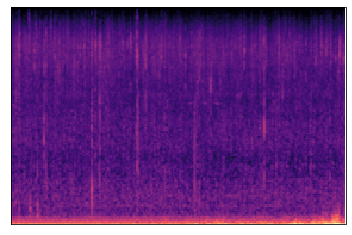

In [47]:
pred={
  'row_id':[],
  'target':[]
}

test_path=input_dir+"/test_soundscapes/"
files=[f.split('.')[0] for f in sorted(os.listdir(test_path))]

birds_path=input_dir+"/scored_birds.json"
with open(birds_path) as bf:
    birds = json.load(bf)
    
converter = AudioToImage(step=int(DURATION*0.666*SR))

for f in files:
    p=test_path+f+'.ogg'
    
    d=librosa.get_duration(filename=p)
    
    mels = converter(p, save=False)
    print(mels.shape)
    
    lbd.specshow(data=mels[11])
    break
    pcs=round(d/5)
    segments = [[] for i in range(pcs)]
      
    for i in range(len(segments)):
        for b in birds:  
            segment_end=(i+1)*5   
            row_id=f+'_'+b+'_'+str(segment_end)
            pred['row_id'].append(row_id)

            pred['target'].append(True)

In [7]:
cols=['row_id','target']
df_sub=pd.DataFrame(pred,columns=cols)

In [8]:
df_sub.to_csv(work_dir+"/submission.csv", index=False)